<a href="https://colab.research.google.com/github/prat-hart/Algorithms/blob/main/Searches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Objectives


*   Read data from a file and Create a graph
*   Implement Uninformed & Informed searching strategies
*   Apply different searching strategies for the given problem
*   Analyze and Compare the searching strategies


## Description

This assignment is focused on **python file reading, graph creation** and implementation of **search algorithms**. 
In the following sections, you will complete a series of tasks for a made up problem of *Coronavirus in Texas*.

*   Coronavirus is non-discriminatory, in the sense that it can spread from one city to any other city. The only goal of the virus is to spread to all cities in Texas. Find a possible way for the virus to spread (Uninformed Search).
*   To counter the effect of the virus, vaccine needs to be distributed to all cities. One city has more demand than supply, whereas one city has a shortage of vaccines. The goal is to find an **optimal** strategy to transport the vaccine (Informed Search) from the city with high supply (low demand) to the city with low supply (high demand).

The base structure and comments are provided on what should be done. You can use some libraries that help support you for the successful completion of the assignment. However, you **CANNOT** use a complete library for the search algorithms. You can get pieces of code from online, but please cite the source properly.


In [ ]:
# Add only your imports here
from google.colab import drive
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
!pip install git+git://github.com/geopandas/geopandas.git
import geopandas as gpd
from shapely.geometry import Point,LineString
from queue import Queue, PriorityQueue
from math import cos, asin, sqrt, pi

In [ ]:
basePath = "/content/drive/My Drive/Colab Notebooks/Artificial Intelligence/Data/"


In [ ]:
# Load the graph data from the files
drive.mount('/content/gdrive/', force_remount=True)
cities = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Artificial Intelligence/Data/cities.csv',header=None, names=['City','Lat','Lon'])
distances=pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Artificial Intelligence/Data/distances.csv',header=None, names=['Start','End', 'Distance' ])
tx= gpd.read_file('/content/gdrive/MyDrive/Colab Notebooks/Artificial Intelligence/Data/tl_2016_48_cousub.zip') #basemap for TX image, shapefile


Mounted at /content/gdrive/


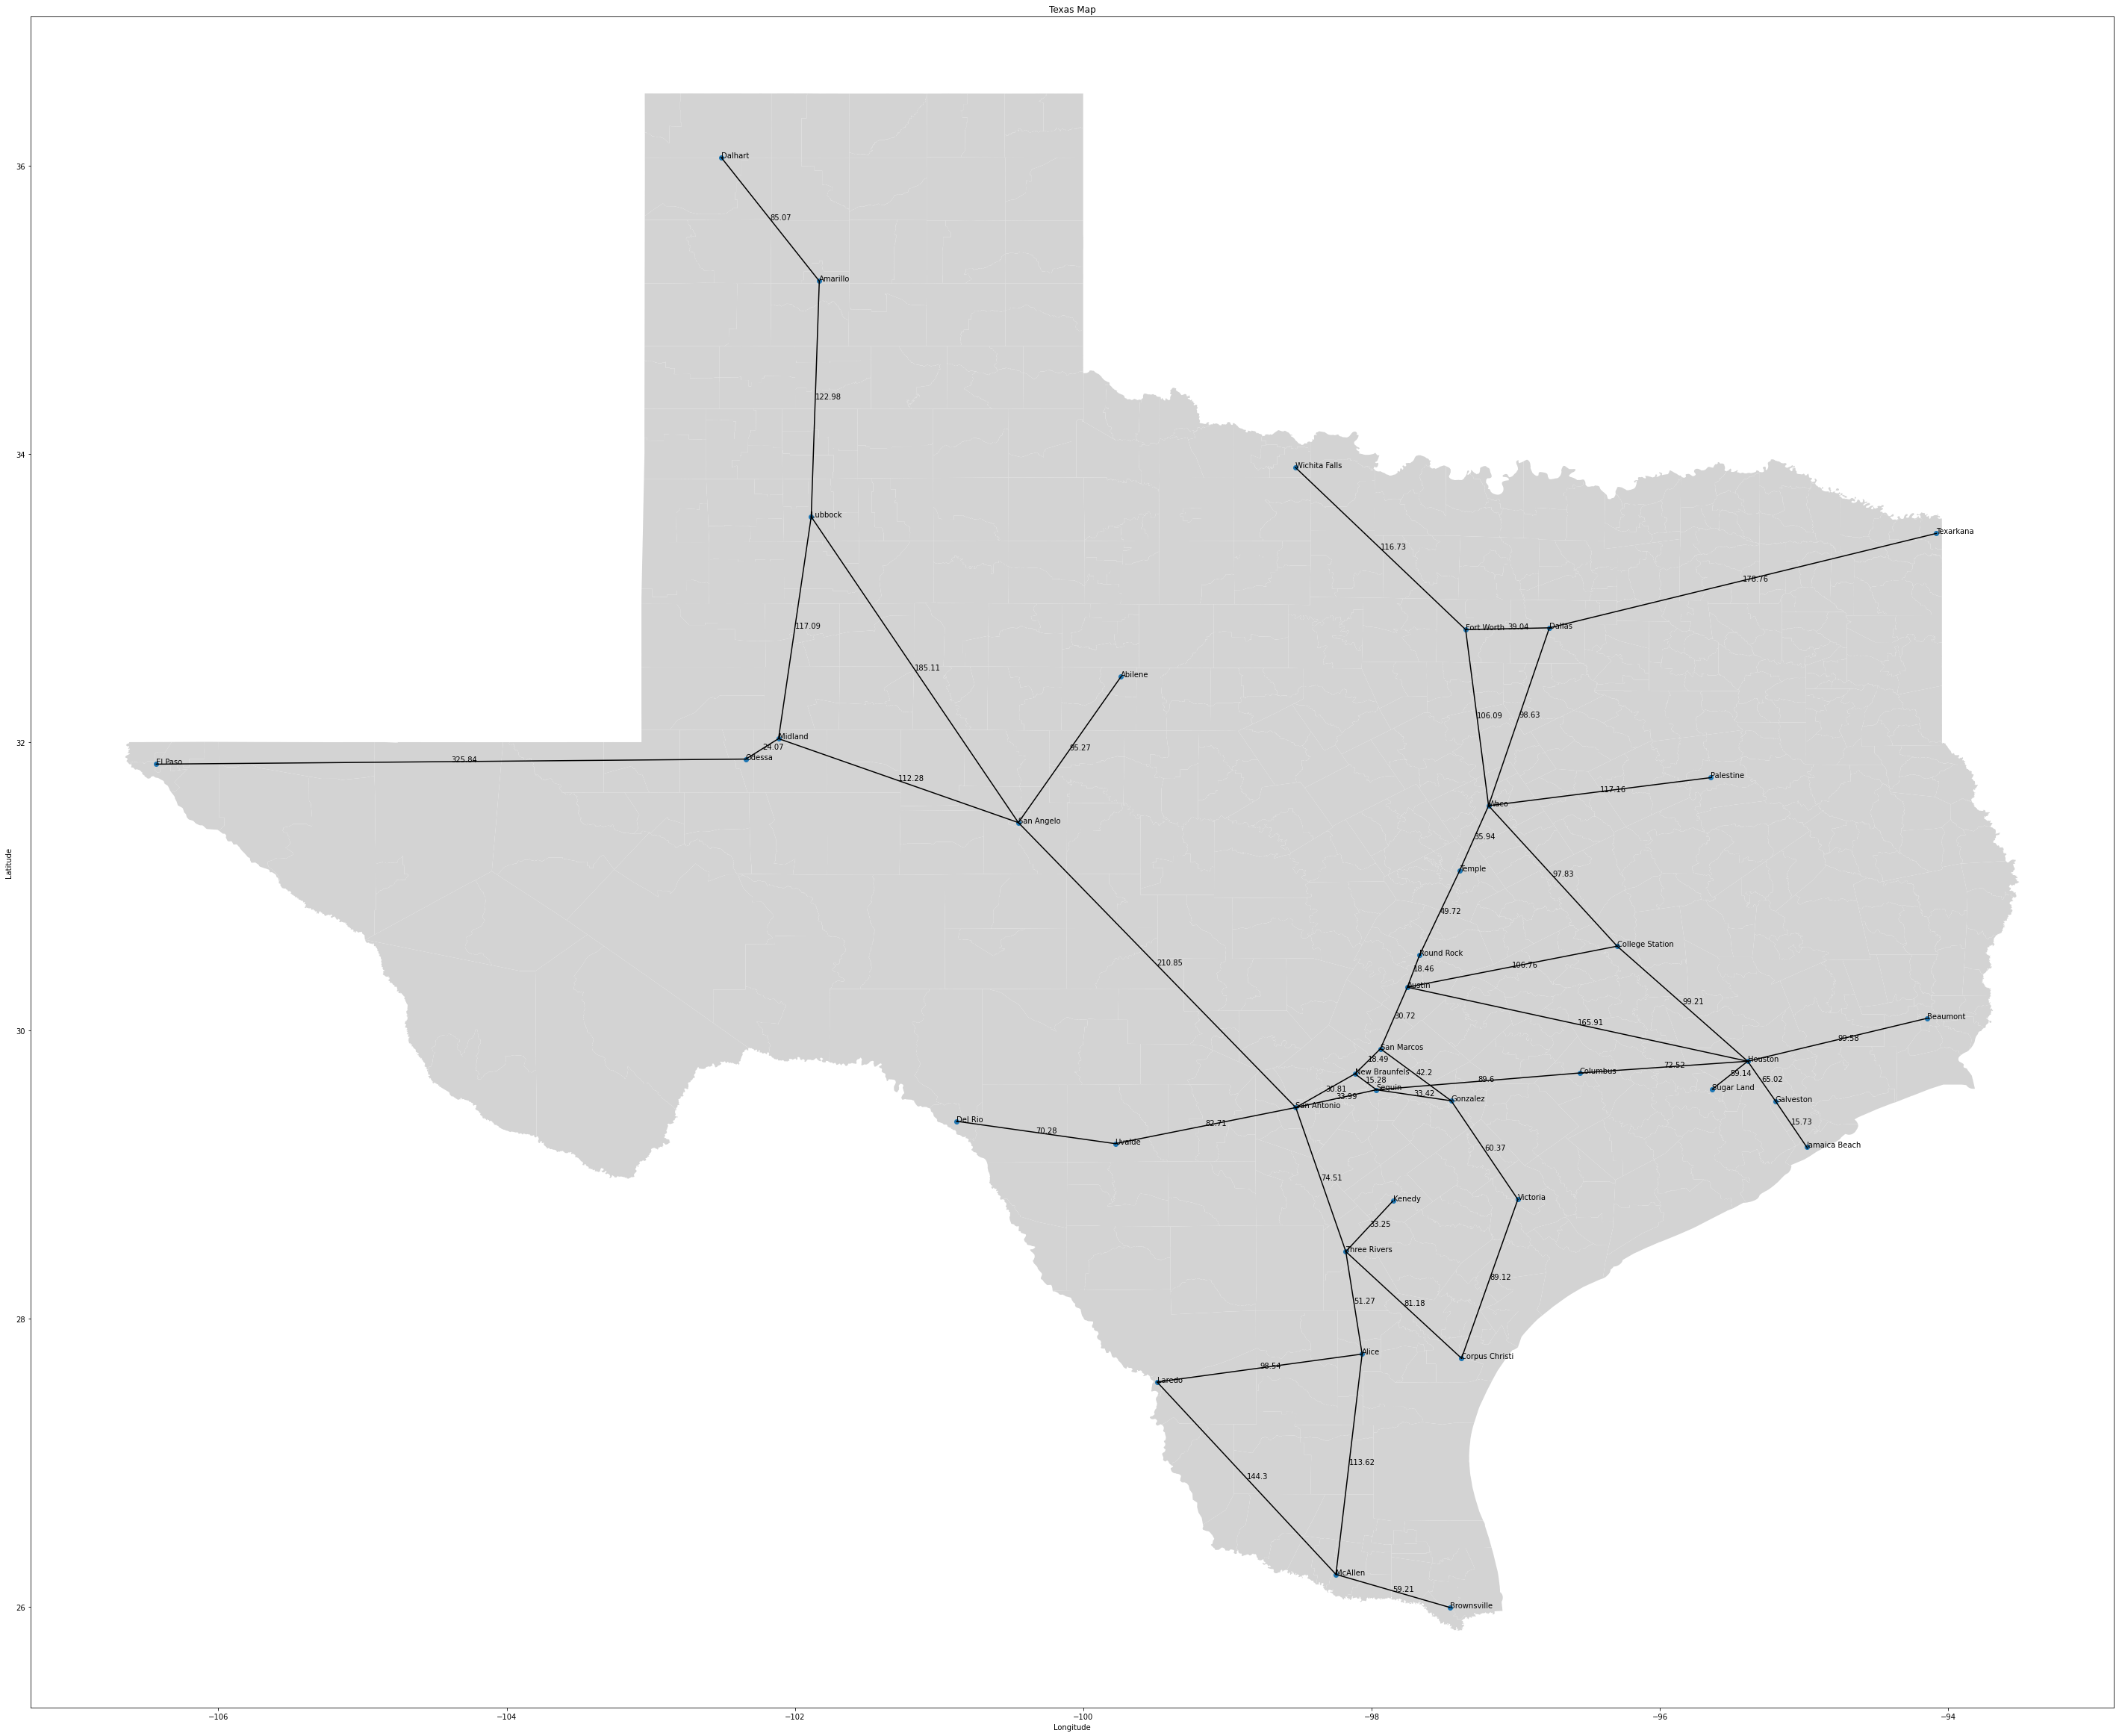

In [ ]:
# Display a 2D graph of the given data.

fig, ax = plt.subplots(figsize = (50,50))

#geopandas for lat/lon exactness and shapefile for image overlay
d={'city':cities['City'], 'geometry':[Point(x,y) for x,y in zip(cities['Lon'],cities['Lat'])]}
df=pd.DataFrame(d)
gdf = gpd.GeoDataFrame(df,crs="EPSG:3857")
tx.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax)
ax.set_title('Texas Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

matrix = np.zeros((len(cities),len(cities))) #initialize 2d (n,n) zero matrix, n=length of city list

for i,city in enumerate(cities['City']): #from cities.csv, i=index of start city, city=string, name of city
  connections_distance = distances.loc[distances['Start']==city,['End','Distance']] #holds the distances between the start city to any connected city
  connections_indexed = [cities.loc[cities["City"]==c].index[0] for c in connections_distance['End']] #replaces the end city with its index from cities.csv
  matrix[i,connections_indexed] = connections_distance['Distance'] 
  plt.annotate(city, (cities['Lon'][i], cities['Lat'][i]))
  connections_location= cities.loc[matrix[i]!=0.,['City','Lon','Lat']] #lat/lon of ends
  hub_location= cities.loc[i,['Lon','Lat']] #lat/lon of start

  for j,row in connections_location.iterrows(): #insert distances in image at midpoint between cities
    x1=row['Lon']
    x2=hub_location['Lon']
    y1=row['Lat']
    y2=hub_location['Lat']
    x_mid= ((x2-x1)/2)+x1
    y_mid=((y2-y1)/2)+y1
    plt.plot([x1,x2],[y1,y2],color="k")
    plt.annotate(str(round(connections_distance.loc[connections_distance['End']==row['City'],'Distance'].iloc[0],2)),(x_mid,y_mid))

#Virus Spread - Uninformed Search Agent


In [ ]:

symmetric_matrix = matrix + matrix.T - np.diag(np.diag(matrix)) 
def uniform_cost_search(graph, start):
  frontier = PriorityQueue()
  explored = list()
  frontier.put((0,0,start,start))
  cumulative_cost=0

  while not frontier.empty():
    cost, prev_cost, current_node, prev_node = frontier.get() #find the closest city
    if current_node in [x[1] for x in explored]:
      continue
    explored.append((prev_node,current_node)) #adds nodes to the explored list
    g = cost
    cumulative_cost += g-prev_cost
   
    for next_node,next_cost in enumerate(graph[current_node]): #indexes each current node and its cost as tuple (index of the city,cost) 
        if next_cost > 0 and next_node not in [x[1] for x in explored]: #make sure there is a connection, and have not been to city
            frontier.put((g+next_cost,g,next_node,current_node)) #adds the tuple into  queue
  return cumulative_cost,explored         

ucs_cost, ucs_path = uniform_cost_search(symmetric_matrix,34)
print(f'Distance travelled:,{ucs_cost}')
start= [x[0] for x in ucs_path]
stop = [x[1] for x in ucs_path]
print(f'Path taken:\n{cities.loc[stop,"City"]}')                           

Distance travelled:,3292.4345778300003
Path taken:
34       Three Rivers
18             Kenedy
1               Alice
28        San Antonio
8      Corpus Christi
23      New Braunfels
30             Seguin
29         San Marcos
15           Gonzalez
19             Laredo
3              Austin
35             Uvalde
21            McAllen
36           Victoria
26         Round Rock
7            Columbus
32             Temple
5         Brownsville
11            Del Rio
37               Waco
6     College Station
16            Houston
27         San Angelo
31         Sugar Land
14          Galveston
17      Jamaica Beach
10             Dallas
13         Fort Worth
4            Beaumont
25          Palestine
0             Abilene
22            Midland
24             Odessa
20            Lubbock
38      Wichita Falls
33          Texarkana
2            Amarillo
9             Dalhart
12            El Paso
Name: City, dtype: object


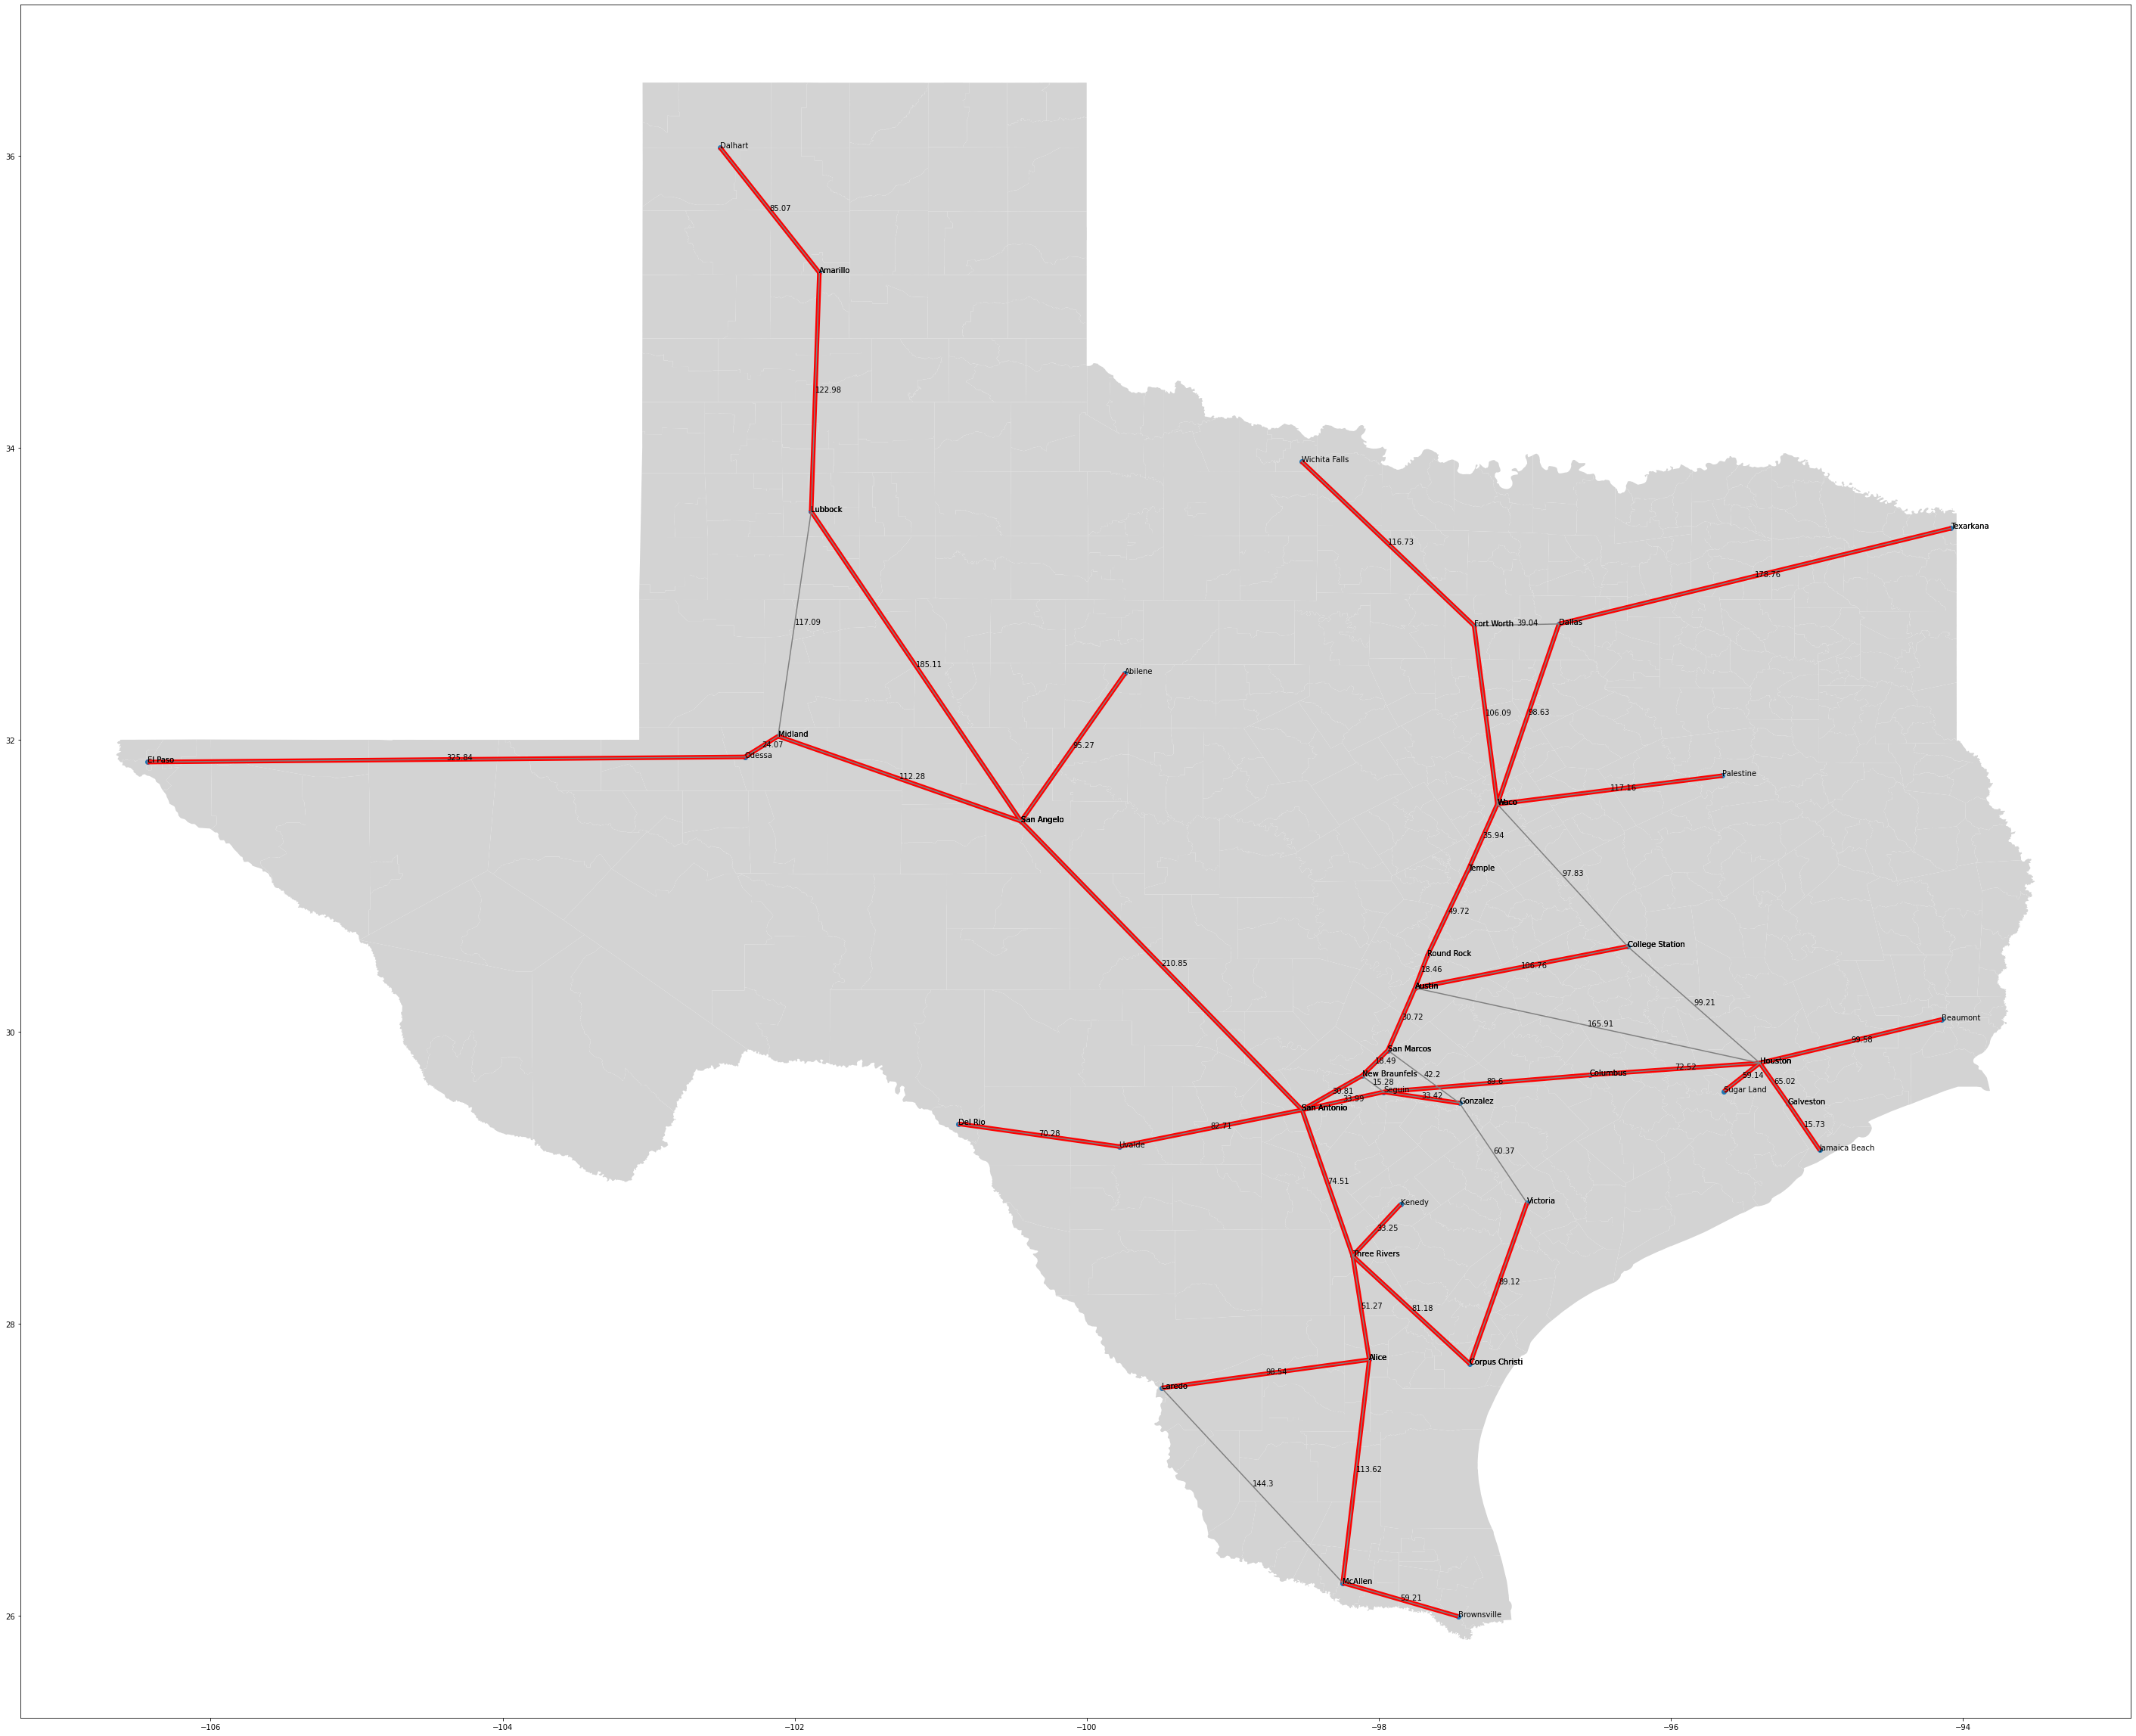

In [ ]:

ucs_start=pd.DataFrame(data={'startLon':cities.loc[start,"Lon"], 'startLat':cities.loc[start,"Lat"]})
ucs_stop=pd.DataFrame(data={'stopLon':cities.loc[stop,"Lon"], 'stopLat':cities.loc[stop,"Lat"]})
x=ucs_start.reset_index(drop=True)
y=ucs_stop.reset_index(drop=True)
r = pd.concat([x, y],axis=1)
k={'start':[Point(x,y) for x,y in zip(r['startLon'],r['startLat'])], 'stop':[Point(x,y) for x,y in zip(r['stopLon'],r['stopLat'])]}
df_3= pd.DataFrame(k)
gdf_3 = gpd.GeoDataFrame(df_3)
gdf_3['line'] = gdf_3.apply(lambda x: LineString([x['start'], x['stop']]), axis=1)


ucs_gdf = gpd.GeoDataFrame(gdf_3, geometry=gdf_3['line'], crs="EPSG:3857")
fig, ax = plt.subplots(figsize = (50,50))
tx.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax)
ucs_gdf.plot(ax=ax, color='red',linewidth=6)

for i,city in enumerate(cities['City']): #from cities.csv, i=index of start city, city=string, name of city
  connections_distance = distances.loc[distances['Start']==city,['End','Distance']] #holds the distances between the start city to any connected city
  connections_indexed = [cities.loc[cities["City"]==c].index[0] for c in connections_distance['End']] #replaces the end city with its index from cities.csv
  matrix[i,connections_indexed] = connections_distance['Distance'] 
  plt.annotate(city, (cities['Lon'][i], cities['Lat'][i]))
  connections_location= cities.loc[matrix[i]!=0.,['City','Lon','Lat']] #lat/lon of ends
  hub_location= cities.loc[i,['Lon','Lat']] #lat/lon of start

  for j,row in connections_location.iterrows(): #insert distances in image at midpoint between cities
    x1=row['Lon']
    x2=hub_location['Lon']
    y1=row['Lat']
    y2=hub_location['Lat']
    x_mid= ((x2-x1)/2)+x1
    y_mid=((y2-y1)/2)+y1
    plt.plot([x1,x2],[y1,y2],color='grey')
    plt.annotate(str(round(connections_distance.loc[connections_distance['End']==row['City'],'Distance'].iloc[0],2)),(x_mid,y_mid))
    plt.annotate(city, (cities['Lon'][i], cities['Lat'][i]))

#Vaccine Transportation - Informed Search Agent



In [ ]:
# Implement an OPTIMAL informed search strategy for distributing the vaccine from 'San Antonio' to 'College Station'
def straight_line_distance(lat1, lon1, lat2, lon2):
  """for each lat,lon combo output straight line distance in miles= hueristics
  """
  p = pi/180
  a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
  return 12742 * asin(sqrt(a)) * 0.621371 #miles

def a_star_search(graph, start, goal):
  """from starting citiy, reach goal in shortest path cost. output path traveled and path cost.
  args- graph=ndarray;collection of edge weights from adjacency matrix
       start=int;index of start city
       goal=int;index of goal city
  returns- distance traveled, path traveled
  """
  sld = cities.apply(lambda x: straight_line_distance(x['Lat'],x['Lon'],cities.loc[goal,'Lat'],cities.loc[goal,"Lon"]),axis=1) #h(n) values
  frontier = PriorityQueue()
  explored = list()
  path=list()
  frontier.put((0+sld[start],start,start)) #tuple with (g(n)+h(n), n)

  while not frontier.empty():
      cost,current_node,came_from = frontier.get() #find the closest city 
      explored.append((came_from,current_node)) #adds nodes to the explored list
      path.append(came_from)
      g = cost-sld[current_node] #the cost of g(n)

      for next_node,next_cost in enumerate(graph[current_node]):
        if next_cost > 0 and next_node not in [x[1] for x in explored]:
          frontier.put((g+next_cost+sld[next_node],next_node,current_node))
          if next_node==goal:
            explored.append((current_node,goal))
            return g+next_cost, explored
            
distance, path = a_star_search(symmetric_matrix,28,6)
print(f'Total distance travelled: {distance}')
cur_node= 6
final_path =[cur_node]
for x in path[::-1]:
  if cur_node == x[1]:
    cur_node=x[0]
    final_path.append(cur_node)
final_path= final_path[:-1][::-1]
print(f'Path taken:\n{cities.loc[final_path,"City"]}')

Total distance travelled: 186.77450141000003
Path taken:
28        San Antonio
23      New Braunfels
29         San Marcos
3              Austin
6     College Station
Name: City, dtype: object


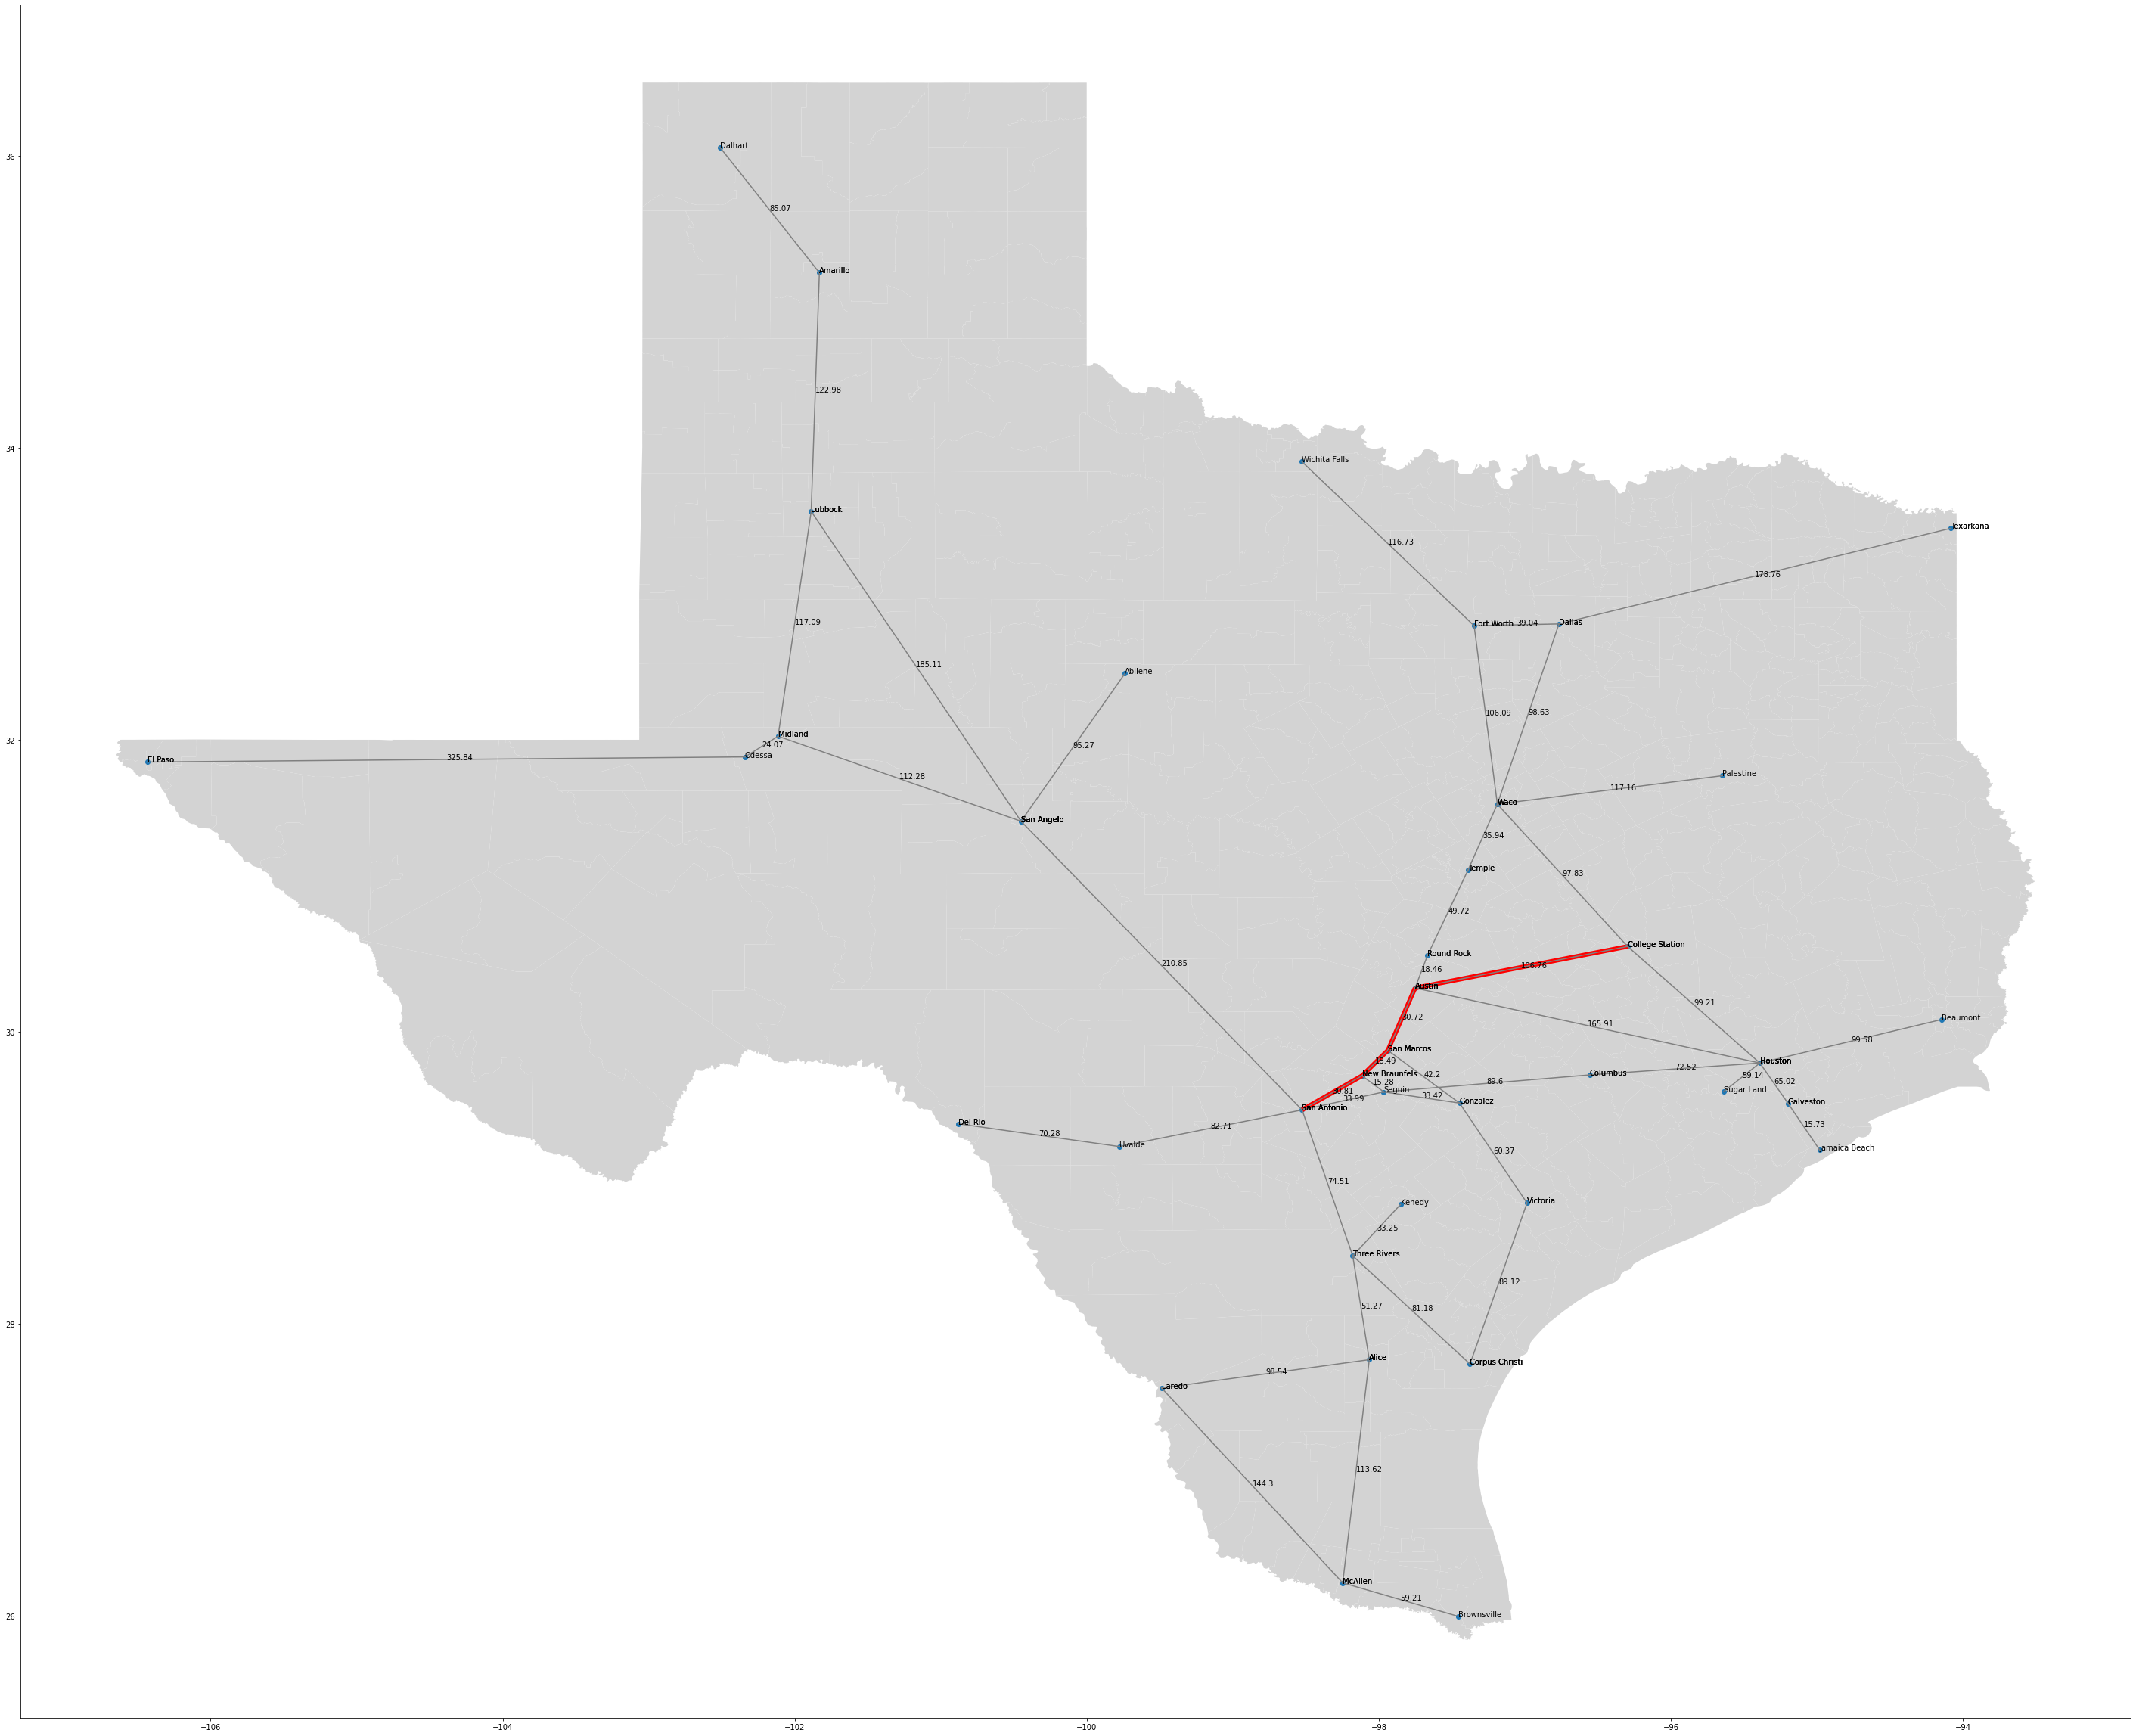

In [ ]:

astar=pd.DataFrame(data={'Lat':cities.loc[final_path,"Lat"], 'Lon':cities.loc[final_path,"Lon"]})
t=astar.reset_index(drop=True)
a={'start':[Point(x,y) for x,y in zip(t['Lon'],t['Lat'])]}
df_2= pd.DataFrame(a)
df_2['stop'] = df_2['start'].shift(-1)
t=df_2.drop(df_2.index[len(df_2)-1])
gdf_2 = gpd.GeoDataFrame(t)
gdf_2['line'] = gdf_2.apply(lambda x: LineString([x['start'], x['stop']]), axis=1)

astar_gdf = gpd.GeoDataFrame(gdf_2, geometry=gdf_2['line'],crs="EPSG:3857")
fig, ax = plt.subplots(figsize = (50,50))
tx.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax)
astar_gdf.plot(ax=ax, color='red',linewidth= 6)

for i,city in enumerate(cities['City']): #from cities.csv, i=index of start city, city=string, name of city
  connections_distance = distances.loc[distances['Start']==city,['End','Distance']] #holds the distances between the start city to any connected city
  connections_indexed = [cities.loc[cities["City"]==c].index[0] for c in connections_distance['End']] #replaces the end city with its index from cities.csv
  matrix[i,connections_indexed] = connections_distance['Distance'] 
  plt.annotate(city, (cities['Lon'][i], cities['Lat'][i]))
  connections_location= cities.loc[matrix[i]!=0.,['City','Lon','Lat']] #lat/lon of ends
  hub_location= cities.loc[i,['Lon','Lat']] #lat/lon of start

  for j,row in connections_location.iterrows(): #insert distances in image at midpoint between cities
    x1=row['Lon']
    x2=hub_location['Lon']
    y1=row['Lat']
    y2=hub_location['Lat']
    x_mid= ((x2-x1)/2)+x1
    y_mid=((y2-y1)/2)+y1
    plt.plot([x1,x2],[y1,y2],color='grey')
    plt.annotate(str(round(connections_distance.loc[connections_distance['End']==row['City'],'Distance'].iloc[0],2)),(x_mid,y_mid))
    plt.annotate(city, (cities['Lon'][i], cities['Lat'][i]))